In [1]:
!ls

'20150525_123348 - Copy.jpg'   pose.caffemodel	 pose.prototxt	 Untitled.ipynb
 human_pose.py		       pose.plan	 __pycache__


In [2]:
from torch.utils.cpp_extension import load

find_peaks = load(name='find_peaks', sources=['find_peaks.cpp'])


In [42]:
refine_peaks = load(name='refine_peaks', sources=['refine_peaks.cpp'])

In [259]:
paf_cost_graph = load(name='paf_cost_graph', sources=['paf_cost_graph.cpp'])

In [1]:
import torch

In [2]:
import torch2trt

In [3]:
import tensorrt as trt
import torchvision

In [375]:
logger = trt.Logger(trt.Logger.INFO)
runtime = trt.Runtime(logger)

In [376]:
with open('pose.plan', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())
    

In [16]:
engine.get_binding_name(2)

'Mconv7_stage6_L2'

In [377]:
model = torch2trt.TRTModule(engine, ['image'], ['Mconv7_stage6_L1', 'Mconv7_stage6_L2'])

In [4]:
import PIL.Image

image = PIL.Image.open('20150525_123348 - Copy.jpg').resize((368, 368)).rotate(270)

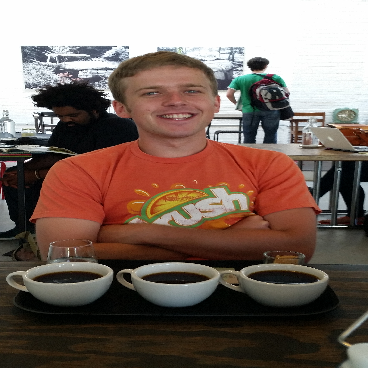

In [6]:
image

In [382]:
inp = torchvision.transforms.ToTensor()(image).cuda().float()[None, ...] - 0.5

In [383]:
paf, cmap = model(inp)

In [64]:
torch.save(paf, 'paf.pt')

In [65]:
torch.save(cmap, 'cmap.pt')

In [42]:
paf = torch.load('paf.pt')
cmap = torch.load('cmap.pt')

In [43]:
cmap = cmap.cpu().float()[:, 0:18]
paf = paf.cpu().float()

In [65]:
cmap.shape

torch.Size([1, 18, 46, 46])

In [9]:
from openpose_topology import PARTS, NUM_PARTS, TOPOLOGY

TOPOLOGY = [
    [1, 0, PARTS.index('NECK'), PARTS.index('RHIP')],
    [3, 2, PARTS.index('RHIP'), PARTS.index('RKNEE')],
    [5, 4, PARTS.index('RKNEE'), PARTS.index('RANKLE')],
    [7, 6, PARTS.index('NECK'), PARTS.index('LHIP')],
    [9, 8, PARTS.index('LHIP'), PARTS.index('LKNEE')],
    [11, 10, PARTS.index('LKNEE'), PARTS.index('LANKLE')],
    [13, 12, PARTS.index('NECK'), PARTS.index('RSHOULDER')],
    [15, 14, PARTS.index('RSHOULDER'), PARTS.index('RELBOW')],
    [17, 16, PARTS.index('RELBOW'), PARTS.index('RWRIST')],
    [19, 18, PARTS.index('RSHOULDER'), PARTS.index('REAR')],
    [21, 20, PARTS.index('NECK'), PARTS.index('LSHOULDER')],
    [23, 22, PARTS.index('LSHOULDER'), PARTS.index('LELBOW')],
    [25, 24, PARTS.index('LELBOW'), PARTS.index('LWRIST')],
    [27, 26, PARTS.index('LSHOULDER'), PARTS.index('LEAR')],
    [29, 28, PARTS.index('NECK'), PARTS.index('NOSE')],
    [31, 30, PARTS.index('NOSE'), PARTS.index('REYE')],
    [33, 32, PARTS.index('NOSE'), PARTS.index('LEYE')],
    [35, 34, PARTS.index('REYE'), PARTS.index('REAR')],
    [37, 36, PARTS.index('LEYE'), PARTS.index('LEAR')],
]

topology = torch.Tensor(TOPOLOGY).int()

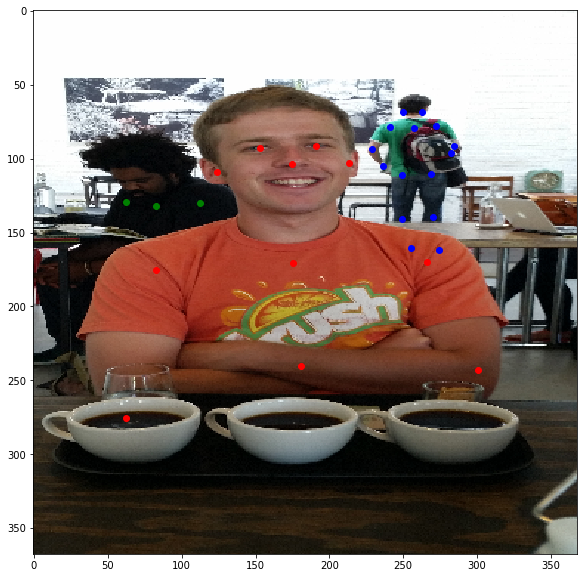

In [21]:
fig = plt.figure(figsize=(10, 10))
for i in range(num_objects):
    if i % 4 == 0:
        color = 'ro'
    elif i % 4 == 1:
        color = 'bo'
    elif i % 4 == 2:
        color = 'go'
    else:
        color = 'go'
        
    for j in range(18):
        p = int(objects[0][i][j])
        if p >= 0:
            peak = refined_peaks[0][j][p]
#             print(peak)
            plt.plot(368*peak[1], 368*peak[0], color)
plt.imshow(image)

In [20]:
num_objects

tensor([3], dtype=torch.int32)

In [11]:
import trt_pose.plugins

In [15]:
num_objects

tensor([[[ 0,  2,  2,  ...,  0,  1,  1],
         [-1,  0,  0,  ..., -1,  0,  0],
         [-1,  1,  1,  ..., -1, -1, -1],
         ...,
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1],
         [-1, -1, -1,  ..., -1, -1, -1]]], dtype=torch.int32)

In [30]:
cmaps = torch.cat([cmap, cmap])
pafs = torch.cat([paf, paf])

In [32]:
pafs.shape

torch.Size([2, 38, 46, 46])

In [23]:
cmap.shape

torch.Size([36, 46, 46])

In [34]:
import matplotlib.pyplot as plt

k = 16

counts, peaks = trt_pose.plugins.find_peaks(cmaps, 0.1, 5, 100)
refined_peaks = trt_pose.plugins.refine_peaks(counts, peaks, cmaps, 5)
score_graph = trt_pose.plugins.paf_score_graph(pafs, topology, counts, refined_peaks, 5)
connections = trt_pose.plugins.assignment(score_graph, topology, counts, -10.0)
num_objects, objects = trt_pose.plugins.connect_parts(connections, topology, counts, 100)
# num_objects, objects = trt_pose.plugins.connect_parts(connections, topology, counts, 100)
  
i_idx = TOPOLOGY[k][0]
j_idx = TOPOLOGY[k][1]
c_a = TOPOLOGY[k][2]
c_b = TOPOLOGY[k][3]

print(PARTS[c_a])
print(PARTS[c_b])
print(connections[0][k])
print(objects[0][0:num_objects])

plt.imshow(cmap[0][c_a].detach().cpu().numpy())
for i in range(counts[0][c_a]):
    p = peaks[0][c_a][i]
    plt.text(p[1], p[0], '%d' % i)
    
plt.show()
plt.imshow(cmap[0][c_b].detach().cpu().numpy())
for i in range(counts[0][c_b]):
    p = peaks[0][c_b][i]
    plt.text(p[1], p[0], '%d' % i)
plt.colorbar()
plt.show()
plt.imshow(paf[0][i_idx].detach().cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(paf[0][j_idx].detach().cpu().numpy())
plt.colorbar()
plt.show()

NOSE
LEYE
tensor([[ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)


TypeError: only integer tensors of a single element can be converted to an index

tensor([[[12, 21],
         [ 0,  0],
         [ 0,  0],
         ...,
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]],

        [[ 9, 32],
         [16, 10],
         [21, 21],
         ...,
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]],

        [[ 9, 34],
         [16,  7],
         [21, 10],
         ...,
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]],

        ...,

        [[11, 23],
         [ 0,  0],
         [ 0,  0],
         ...,
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]],

        [[ 8, 32],
         [13, 15],
         [ 0,  0],
         ...,
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]],

        [[ 8, 31],
         [12, 26],
         [ 0,  0],
         ...,
         [ 0,  0],
         [ 0,  0],
         [ 0,  0]]], dtype=torch.int32)

In [8]:
import trt_pose.plugins

In [438]:
counts, peaks = find_peaks.forward(cmap, 0.1, 3, 100)

In [ ]:
trt_pose.plugins.

In [309]:
from openpose_topology import PARTS, NUM_PARTS, TOPOLOGY
topology = torch.Tensor(TOPOLOGY).int()

In [47]:
import time

t0 = time.time()

for i in range(1000):
    if i % 2== 0:
        cmap_a = cmap + 0.00001
    else:
        cmap_a = cmap
    counts, peaks = trt_pose.plugins.find_peaks(cmap_a, 0.1, 5, 100)
    refined_peaks = trt_pose.plugins.refine_peaks(counts, peaks, cmap_a, 5)
    score_graph = trt_pose.plugins.paf_score_graph(paf, topology, counts, refined_peaks, 5)
    connections = trt_pose.plugins.assignment(score_graph, topology, counts, -10.0)
    num_objects, objects = trt_pose.plugins.connect_parts(connections, topology, counts, 100)

t1 = time.time()
print((t1 - t0) / 1000.0)

0.0006915051937103271


In [259]:
counts[0][17]

tensor(2, dtype=torch.int32)

In [31]:
a = [1,2,3]

In [37]:
a.insert(0, 1)

In [39]:
len(a)

1

In [17]:
def connect_parts(connections, topology, counts, max_count):
    N = counts.shape[0]
    K = topology.shape[0]
    C = counts.shape[1]
    M = connections.shape[3]
    
    visited = torch.zeros((N, C, M)).int()
    objects = -torch.ones((N, max_count, C)).int()
    num_objects = 0
    for n in range(N):
        for c in range(C):
            
            count = counts[n][c]
            
            for i in range(count):
                
                # BFS 
                q = [(c, i)]
                new_object = False
                
                while len(q) > 0:
                    
                    c_n, i_n = q.pop()
                    
                    if visited[n][c_n][i_n]:
                        continue
                        
                    visited[n][c_n][i_n] = 1
                    new_object = True
                    objects[n][num_objects][c_n] = i_n
                    
                    # continue with search otherwise
                    for k in range(K):
                        
                        c_a = topology[k][2]
                        c_b = topology[k][3]
                        
                        if c_a == c_n:
                            i_b = connections[n][k][0][i_n]
                            if i_b >= 0:
                                q.insert(0, (c_b, i_b))
                        elif c_b == c_n:
                            i_a = connections[n][k][1][i_n]
                            if i_a >= 0:
                                q.insert(0, (c_a, i_a))
                
                if new_object:
                    num_objects += 1
                    if num_objects >= max_count:
                        return objects, num_objects
    
    return num_objects, objects

In [263]:
objects, num_objects = connect_parts(connections, topology, counts, 100)

In [289]:
score_graph[0][0]

tensor([[ 0.9433,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0049,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0045,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [287]:
c = 1
print(PARTS[c])
peaks[0][c][0]

NECK


tensor([ 9, 32], dtype=torch.int32)

In [264]:
objects[0][0:5]

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  1.],
        [-1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
         -1., -1., -1., -1.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1.,  0.],
        [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
         -1., -1., -1., -1.]])

In [216]:
k = 9
c_a = TOPOLOGY[k][2]
c_b = TOPOLOGY[k][3]

print(counts[0][c_a])
print(counts[0][c_b])
print(score_graph[0][k])
print(connections[0][k])

tensor(3, dtype=torch.int32)
tensor(2, dtype=torch.int32)
tensor([[6.2047e-01, 5.7893e-02, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.2692e-04, 6.3520e-04, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.5818e-01, 5.6693e-01, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])
tensor([[ 0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -

In [197]:
c_b

8

In [186]:
objects[0][1].ge(0).nonzero()

tensor([[1],
        [2],
        [5]])

In [123]:
TOPOLOGY

[[1, 0, 1, 8],
 [3, 2, 8, 9],
 [5, 4, 9, 10],
 [7, 6, 1, 11],
 [9, 8, 11, 12],
 [11, 10, 12, 13],
 [13, 12, 1, 2],
 [15, 14, 2, 3],
 [17, 16, 3, 4],
 [19, 18, 2, 16],
 [21, 20, 1, 5],
 [23, 22, 5, 6],
 [25, 24, 6, 7],
 [27, 26, 5, 8],
 [29, 28, 1, 0],
 [31, 30, 0, 14],
 [33, 32, 0, 15],
 [35, 34, 14, 16],
 [37, 36, 15, 17]]

In [146]:
score_graph.max()

tensor(1.0181)

In [144]:
connections[0][10]

tensor([[ 0,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

In [109]:
TOPOLOGY[5]

[11, 10, 12, 13]

In [154]:
PARTS[TOPOLOGY[10][3]]

'LSHOULDER'

In [101]:
connections[0][6]

tensor([[ 0,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  1,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

In [88]:
objects[0][]

tensor([-1.,  0., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1.])

In [ ]:
conne

In [14]:
score_graph[0][0]

tensor([[ 0.9433,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0049,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0045,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [15]:
counts

tensor([[  1,   3,   3,   2,   1,   3,   2,   2,   1,   1,   1,   1,   1,   2,
           1,   1,   2,   2, 100]], dtype=torch.int32)

In [25]:
score_graph[0][7]

tensor([[ 0.7002,  0.0024,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0029,  0.0544,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0339,  0.4667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [26]:
connections[0][7]

tensor([[ 0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [ 0,  2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]], dtype=torch.int32)

In [93]:
counts[0][topology[7][3]]

tensor(6, dtype=torch.int32)

In [26]:
out = trt_pose.plugins.munkres(-cost_graph, topology, counts, 0.1, 10)

In [39]:
cost_graph[0][7]

tensor([[ 0.7002,  0.0024,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0029,  0.0544,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0339,  0.4667,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [37]:
out[0][7]

tensor([[0.0000, 0.4644, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [0.7032, 0.4123, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [0.7342, 0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]])

In [25]:
cost_graph.max()

tensor(1.0181)

In [362]:
print(peaks[0][1][0])
print(refined_peaks[0][1][0])

tensor([ 9, 32], dtype=torch.int32)
tensor([0.2114, 0.7020])


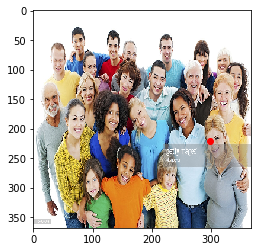

In [116]:
peak = refined_peaks[0][14][17]
plt.imshow(image)
plt.plot(peak[1] * 368.0, peak[0] * 368, 'ro')
plt.show()

// paf = Nx(2*K)xHxW
// topology = Kx4 --> (paf_i_idx, paf_j_idx, cmap_a_idx, cmap_b_idx)
// counts = NxC
// peaks = NxCxMx2
// cost_graph = NxKxMxM

In [371]:
topology = torch.Tensor(TOPOLOGY).int()

In [290]:
cost_graph = trt_pose.plugins.paf_score_graph(paf, topology, counts, refined_peaks, 5)

In [398]:
k = 10
print(TOPOLOGY[k])
print(PARTS[TOPOLOGY[k][2]])
print(PARTS[TOPOLOGY[k][3]])
print(refined_peaks[0][TOPOLOGY[k][2]][0:3, 0:3])
print(refined_peaks[0][TOPOLOGY[k][3]][0:3, 0:3])
cost_graph[0][k]

[21, 20, 1, 5]
NECK
LSHOULDER
tensor([[0.2114, 0.7020],
        [0.3585, 0.2272],
        [0.4651, 0.4720]])
tensor([[0.2111, 0.6584],
        [0.3551, 0.3119],
        [0.4635, 0.7274]])


tensor([[ 0.8768,  0.1576, -0.0108,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0162,  0.0763,  0.1381,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0897, -0.1191,  0.8111,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [ ]:
trt_pose.plugins.paf_score_graph(paf, topology, counts, refined_peaks, 5)

In [384]:
cost_graph[0][6]

tensor([[ 0.8684, -0.0855, -0.0796,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0708,  0.1202,  0.0051,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0152,  0.1525,  0.6885,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

In [209]:
topology[0]

tensor([0, 1, 0, 1], dtype=torch.int32)

In [302]:
paf = torch.Tensor([[
    [
        [1.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0],
        [1.0, 0.0, 0.0, 0.0]
    ],
    [
        [1.0, 1.0, 1.0, 1.0],
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0]
    ]
]])
topology = torch.Tensor([[0, 1, 0, 1]]).int()
peaks = torch.zeros((1, 2, 2, 2)).float()
peaks[0][0][0] = torch.Tensor([0.0, 0.0])
peaks[0][1][0] = torch.Tensor([0.0, 1.0])
peaks[0][1][1] = torch.Tensor([1.0, 0.0])
counts = torch.Tensor([[1, 2]]).int()

In [303]:
trt_pose.plugins.paf_score_graph(paf, topology, counts, peaks, 5)

tensor([[[[1.0000, 1.0000],
          [0.0000, 0.0000]]]])

In [355]:
cost_graph = paf_cost_graph.forward(paf, topology, counts, peaks, 10)

In [356]:
cost_graph[0][0]

tensor([[1.0000, 1.4142],
        [0.0000, 0.0000]])

In [174]:
paf.shape

torch.Size([1, 2, 4, 4])

In [437]:
munkres_assignment = load(name='munkres_assignment', sources=['munkres_assignment.cpp', 'Munkres.cpp'])